In [9]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt, ceil
import numpy as np

out = 'H:\\My Drive\\PROJECTS\\PSI 2022-2025\\caltarget paper\\figures\\'

In [2]:
df = pd.read_csv('P:\\SUPERCAM_from_PDS\\LIBS_RDR_metadata_w_pred_comps.csv')
df = df[df.target.str.contains('scct')].sort_values('target', ignore_index=True)

comp_cols = [c for c in df.columns if 'O' in c and 'stdev' not in c]

# actual values from calibration metadata
actual_df = pd.read_csv('G:\\My Drive\\Darby Work\\SuperCam calibration\\data\\SuperCam_cal_shift-2pix_metadata.csv')
# SAMPLE SFC_2019_0409115755_01_PMIDN0303____________LCD0_FMEQM_01L01_shift-2pix.fits WAS LABELLED INCORRECTLY!
actual_cols = list(comp_cols)
actual_cols.insert(0,'Target_Name')
actual_df = actual_df[actual_cols].drop_duplicates()
actual_cols = [a+'_actual' for a in actual_cols[1:]]
actual_cols.insert(0,'Target_Name')
actual_df.columns = actual_cols

# key to match meta target name to SCCT target name
sample_key = pd.read_excel('P:\\SUPERCAM_from_PDS\\SCCT_key.xlsx', skiprows=2)
sample_key = sample_key[['Target Name','Metadata Name']]

# add key
df = df.merge(sample_key, how='left', left_on='target', right_on='Target Name').drop(columns='Target Name')
# add actual compositions
df = df.merge(actual_df, how='left', left_on='Metadata Name', right_on='Target_Name').drop(columns=['Metadata Name', 'Target_Name'])

# add sol range label
range_names = []
ranges = np.arange(df.sol.min(), df.sol.max()+100, step=100)
df.insert(2,'sol_range', None)
for i in np.arange(len(ranges)-1):
    minimum = ranges[i]
    maximum = ranges[i+1]
    name = f'{minimum}-{maximum}'
    range_names.append(name)
    
    df.loc[(df.sol>=minimum)&(df.sol<maximum), 'sol_range'] = name

In [3]:
# get reported accuracy
reported_stats = pd.read_csv('P:\\SUPERCAM_from_PDS\\supercam_libs_moc.csv', nrows=7)
reported_stats = reported_stats[[c for c in reported_stats.columns if 'Unnamed' not in c]]

report_rmse = dict()
for oxide in comp_cols:
    report_rmse[oxide] = reported_stats[reported_stats['Training set Quartiles']=='RMSEP'][oxide].values[0]

In [4]:
df.target.value_counts()

scct pmian0106     17
scct tsrich0404    11
scct pmifs0505     11
scct nte020106     10
scct tapag0206     10
scct sherg02       10
scct pmifa0306     10
scct nte050301     10
scct nte010301     10
scct ljmn10106     10
scct lcmb0006      10
scct lca530106     10
scct nte030106      9
scct nte040106      9
scct lside0101      9
scct pmidn0302      9
scct pmien0602      9
scct pmior0507      9
scct tserp0102      9
scct lanke0101      9
scct lbhvo20406     8
scct ljsc10304      8
Name: target, dtype: int64

### by time period

In [5]:
# RMSE per sol range
rmse_dict = dict()
for ct in df['target'].unique():
    temp = df[df.target==ct].copy()
    ct_results = []
    
    for s in temp.sol_range.values:
        temp_results = [s]
        
        temp_sol = temp[temp.sol_range==s].copy()
        # if only one measurement, just use squared error
        if len(temp_sol)==1:           
            for c in comp_cols:
                t = temp_sol.dropna(subset=[c+'_actual'])
                if len(t) == 0:
                    temp_results.append(np.nan)
                else:
                    se = abs(t[c+'_actual'].values[0] - t[c].values[0])
                    temp_results.append(se)
        
        else:
            for c in comp_cols:
                t = temp_sol.dropna(subset=[c+'_actual'])
                if len(t) == 0:
                    temp_results.append(np.nan)
                else:
                    rmse = sqrt(mean_squared_error(t[c+'_actual'], t[c]))
                    temp_results.append(rmse)
                
        # add to results for the target
        ct_results.append(temp_results)
        
    rmse_dict[ct] = ct_results
    
# combine CT results
rmse_cols = [c+'_RMSE' for c in comp_cols]
rmse_cols.insert(0,'sol_range')

count=0
for ct in df['target'].unique():
    temp = pd.DataFrame(rmse_dict[ct], columns=rmse_cols)
    temp.insert(0,'target',ct)
    
    if count==0:
        rmse_results = temp.copy()
    else:
        rmse_results = pd.concat([rmse_results, temp], ignore_index=True)
    count+=1
rmse_results.drop_duplicates(inplace=True, ignore_index=True)
        
# summarize per sol
mean = rmse_results.groupby('sol_range', as_index=False).mean()
mean_cols = [c+'_mean' for c in rmse_cols[1:]]
mean_cols.insert(0,'sol_range')
mean.columns = mean_cols

std = rmse_results.groupby('sol_range', as_index=False).std()
std_cols = [c+'_std' for c in rmse_cols[1:]]
std_cols.insert(0,'sol_range')
std.columns = (std_cols)

rmse_summary = mean.merge(std)

# reorder
new_cols = list(rmse_summary.columns[1:])
new_cols.sort()
new_cols.insert(0,'sol_range')
rmse_summary.columns = new_cols

# add number of samples per group
n_samples = rmse_results.groupby('sol_range', as_index=False).size()
n_samples.rename(columns={'size':'n_samples'}, inplace=True)
rmse_summary = n_samples.merge(rmse_summary)

# export findings
rmse_summary.to_csv('SuperCam_RMSE_bysol_summary.csv', index=False)
rmse_results.to_csv('SuperCam_RMSE_bysol.csv', index=False)

#### pred/true

In [6]:
# avg values per time period
mean_cols = [c+'_mean' for c in comp_cols]
std_cols = [c+'_std' for c in comp_cols]
mean_cols.insert(0,'sol_range')
std_cols.insert(0,'sol_range')

count=0
for ct in df.target.unique():
    temp = df[df.target==ct].copy()
    mean = temp.groupby('sol_range', as_index=False)[comp_cols].mean()
    mean.columns = list(mean_cols)
    stdev = temp.groupby('sol_range', as_index=False)[comp_cols].std()
    stdev.columns = list(std_cols)
    
    full = mean.merge(stdev)
    full.insert(0,'target', ct)
    
    if count == 0:
        sol_results = full.copy()
    else:
        sol_results = pd.concat([sol_results,full], ignore_index=True)
    count+=1

sol_results.fillna(0, inplace=True)

# add actual values
actual_cols.remove('Target_Name')
actual_cols.insert(0, 'target')
sol_results = sol_results.merge(df[actual_cols], how='left')

# average by sample
avg_results = sol_results.groupby('target', as_index=False).mean()

### Plots
#### Bar plot

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

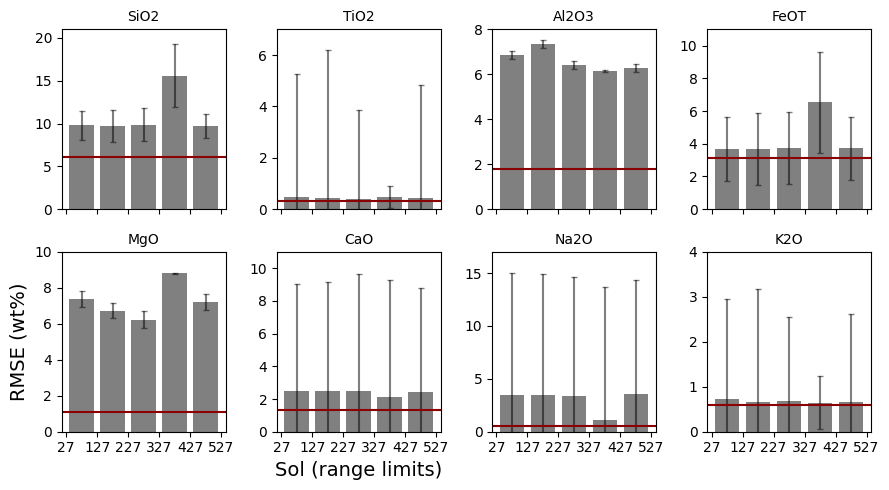

In [10]:
size = 10

x_labels = list(ranges)
x = np.arange(len(x_labels)-1)
x_ticks = xticks = [x-.5 for x in np.arange(len(x)+1)]

fig, ax = plt.subplots(nrows=2, 
                       ncols=4,
                       figsize=(9,5),
                       sharex=True)

y_ax = [0,1,2,3,0,1,2,3]
x_ax = [0,0,0,0,1,1,1,1]
i = 0

comps = ['SiO2','TiO2','Al2O3','FeOT','MgO','CaO','Na2O','K2O']
for oxide in comps:
    
    # values
    yvals = rmse_summary[oxide+'_RMSE_mean']
    yerr = rmse_summary[oxide+'_RMSE_std']
    n_stds = rmse_summary['n_samples']
    report = report_rmse[oxide]

    # actual error
    bar = ax[x_ax[i],y_ax[i]].bar(x, yvals, color='grey', zorder=0)
    
    # uncertainty
    ax[x_ax[i],y_ax[i]].errorbar(x, yvals, yerr=yerr, capsize=2, linestyle="", color='black', alpha=0.5)
    
    # number of standards
#    if i==0:
#    ax[x_ax[i],y_ax[i]].bar_label(bar, n_stds)
    
    # reported error
    ax[x_ax[i],y_ax[i]].axhline(report, color='darkred')
    
    ax[x_ax[i],y_ax[i]].set_title(oxide, fontsize=10)
#    ax[x_ax[i],y_ax[i]].set_title(f'Reported: {report}    Actual: {round(yvals.mean(),2)} +/- {round(yvals.std(),2)}',
#                fontsize=size-1)
    
    # set axes
    ymin, ymax = ax[x_ax[i],y_ax[i]].get_ylim()
    ymin = 0
    ylimit = ceil(ymax)
    if ymax < ylimit:
        ymax = ylimit
    ax[x_ax[i],y_ax[i]].set_ylim((ymin,ymax))
    
    # labels and ticks)
    ax[x_ax[i],y_ax[i]].set_xticks(x_ticks)
    ax[x_ax[i],y_ax[i]].set_xticklabels(labels=x_labels, fontsize=size)
    
    i+=1

#plt.annotate('Numbers above bars signify number of caltargets analysed during that time period',
#            (.1, .9), xycoords='figure fraction')
ax[1,1].set_xlabel('Sol (range limits)', fontsize=14)
ax[1,0].set_ylabel(f'RMSE (wt%)', fontsize=14)
plt.tight_layout()
plt.savefig(out+'SCCT_rmsep_over_time_bar_plot.eps', dpi=600)
plt.show()

### by sample
Get average prediction and stdev of that for pred/true

In [8]:
# number of duplicates
dup_df = pd.DataFrame(df.groupby('target').size()).rename(columns={0:'n_dups'})

# average value
mean_df = df.groupby('target')[comp_cols].mean()
mean_df.columns = [c+'_mean' for c in comp_cols]

# stdev of values
stdev_df = df.groupby('target')[comp_cols].std()
stdev_df.columns = [c+'_std' for c in comp_cols]

# merge results
results_df = dup_df.join(mean_df).join(stdev_df).reset_index()

# actual values from calibration metadata
actual_df = pd.read_csv('G:\\My Drive\\Darby Work\\SuperCam calibration\\data\\SuperCam_cal_shift-2pix_metadata.csv')
actual_cols = list(comp_cols)
actual_cols.insert(0,'Target_Name')
actual_df = actual_df[actual_cols].drop_duplicates()
actual_cols = [a+'_actual' for a in actual_cols[1:]]
actual_cols.insert(0,'Target_Name')
actual_df.columns = actual_cols

# key to match meta target name to SCCT target name
sample_key = pd.read_excel('P:\\SUPERCAM_from_PDS\\SCCT_key.xlsx', skiprows=2)
sample_key = sample_key[['Target Name','Metadata Name']]

# add key
results_df = results_df.merge(sample_key, how='left', left_on='target', right_on='Target Name').drop(columns='Target Name')
# add actual compositions
results_df = results_df.merge(actual_df, how='left', left_on='Metadata Name', right_on='Target_Name').drop(columns=['Metadata Name', 'Target_Name'])

# sort columns
all_cols = list(results_df.columns[2:])
all_cols.sort()
all_cols.insert(0,'target')
all_cols.insert(1,'n_dups')
results_df = results_df[all_cols]

results_df.to_csv('SuperCam_pred_true_summary.csv', index=False)